In [1]:
from forcast_utils import preprocessing
import jax
from flax import nnx
import jax.numpy as jnp
import pandas as pd
import tqdm
from functools import partial


In [2]:
# First we need to define some Hyperparameters so that we can change them easily
VOLATILITY_WINDOW = 5  # Window size for calculating volatility in days
TIMESERIES_LENGTH = 60  # Length of the time series to use for training
BATCH_SIZE = 32  # Batch size for training
EPOCHS = 20  # Number of epochs to train the model

SHOW_DEBUG_INFO = True  # Whether to show debug information during training



Lets first download the data.

In [3]:
btc = preprocessing.download_data('BTC-USD', start='2015-01-01', end='2023-10-01')
#btc = yf.download('BTC-USD', start='2015-01-01', end='2023-10-01')
if SHOW_DEBUG_INFO:
    print(f"Downloaded {len(btc)} rows of data for BTC-USD")
    print(f"Columns: {btc.columns.tolist()}")
    print(f"Data types:\n{btc.dtypes}")
    btc.info()

Data for BTC-USD already downloaded.
Downloaded 3195 rows of data for BTC-USD
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Data types:
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 3195 entries, 2015-01-01 to 2023-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3195 non-null   float64
 1   High    3195 non-null   float64
 2   Low     3195 non-null   float64
 3   Open    3195 non-null   float64
 4   Volume  3195 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 149.8+ KB


In [4]:
data = preprocessing.preprocess_data(btc.copy(), target_column="Target", feature_columns=['Open', 'High', 'Low', 'Close', 'Volume'], window=VOLATILITY_WINDOW)
data_preprocessed = preprocessing.drop_columns(data.copy(), ['Open', 'High', 'Low', 'Close', 'Volume', 'Log_Returns_5_Volatility', 'Log_Returns'])

if SHOW_DEBUG_INFO:
    print(data_preprocessed.info())
    print(data_preprocessed.head())
    # max entry for each column
    print(data_preprocessed.median())



Using base column: Log_Returns_5_Volatility_Variance to create target column: Target
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3189 entries, 0 to 3188
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Target                             3189 non-null   float64
 1   Log_Returns_5_Volatility_Variance  3189 non-null   float64
dtypes: float64(2)
memory usage: 50.0 KB
None
     Target  Log_Returns_5_Volatility_Variance
0  0.089127                           0.096965
1  0.096965                           0.045087
2  0.045087                           0.020667
3  0.020667                           0.037170
4  0.037170                           0.028829
Target                               0.012634
Log_Returns_5_Volatility_Variance    0.012628
dtype: float64


wNow let's create a simple LSTM model to predict the volatility...

In [34]:
if SHOW_DEBUG_INFO:
    from forcast_utils import models as custom_forcast_models
    print("Creating LSTM model...")
    garch = custom_forcast_models.GARCHModel()
    lstm = custom_forcast_models.LSTM(1, 256, nnx.Rngs(jax.random.PRNGKey(0)))
    nnx.display(garch)
    nnx.display(lstm)

Creating LSTM model...


In [35]:
import optax
from forcast_utils.models import LSTM

def t_loss_fn(model: LSTM, x: jnp.ndarray, y: jnp.ndarray, v: int) -> jnp.ndarray:
    """ This function implements the T-loss function. Which is a loss function modeled after the Student's t-distribution.
    v is the degrees of freedom parameter. The lower the v, the heavier the tails of the distribution."""
    assert v > 2, "Degrees of freedom v must be greater than 2 for the T-loss function to be well-defined."
    y_pred = model(x) # TODO we should look if y pred is the variance or the std deviation
    loss = jnp.mean(jnp.log(jnp.square(y_pred))/2 + (v+1)/2 * jnp.log(1 + (y/((v -2) * jnp.square(y_pred)))))
    return loss


# Alright, now lets define some helper functions
def compute_metrics(predictions: jnp.ndarray, targets: jnp.ndarray) -> dict:
    """Compute metrics for the model predictions."""
    mse = jnp.mean((predictions - targets) ** 2)
    mae = jnp.mean(jnp.abs(predictions - targets))
    return {'mse': mse, 'mae': mae}

def create_training_state(rng: nnx.Rngs) -> tuple[nnx.Module, optax.GradientTransformation]:
    """Create a training state for the model."""
    lstm = LSTM(features=6, rngs=rng)
    tx = optax.adam(1e-3)
    return lstm, tx

def loss_fn(model: LSTM, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    y_pred = model(x)
    return jnp.mean((y_pred - y) ** 2)

@nnx.jit
def train_step(model, optimizer, x, y):
#  loss_fn = partial(t_loss_fn, v=5)  # Using a fixed v for the T-loss function
  grad_fn = nnx.value_and_grad(loss_fn)
  loss, grads = grad_fn(model, x, y)
  optimizer.update(grads)  # In place updates.
  return loss

def transform_data_to_training_timeseries(data: pd.DataFrame, window_size: int = 100) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Transform the DataFrame into a time series format for training."""
    # Convert DataFrame to JAX array
    y = jnp.array(data['Target'])
    x_unformatted = jnp.array(data.drop(columns=['Target']))
    x = jnp.array([x_unformatted[i:i + window_size] for i in range(len(x_unformatted) - window_size)])
    y = y[window_size:] # drop label for series that are not complete
    return x, y

def train_test_split(data: pd.DataFrame, test_size: float = 0.2) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Split the data into training and testing sets."""
    split_index = int(len(data) * (1 - test_size))
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data


In [38]:
# Now we can run the training loop
from sklearn.utils import shuffle
from forcast_utils import models as custom_forcast_models

def train_model(model, optimizer, X_train: jnp.ndarray, Y_train: jnp.ndarray, epochs: int = 10, batch_size: int = 32):
    """Train the LSTM model."""
    for epoch in tqdm.tqdm(range(epochs)):
        aggregate_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            x_batch: jnp.array = X_train[i:i + batch_size]
            y_batch: jnp.array = Y_train[i:i + batch_size]
            loss = train_step(model, optimizer, x_batch, y_batch)
            aggregate_loss += loss
        average_loss = aggregate_loss / batch_size
        print(f"Epoch {epoch + 1}, AVG Loss: {average_loss:.8f}")

# Define feature columns to be used



# Split the data into training and testing sets
train_data, test_data = train_test_split(data_preprocessed, test_size=0.2)


X_train, y_train = transform_data_to_training_timeseries(train_data, window_size=TIMESERIES_LENGTH)
# shuffle the timeseries data
shuffled_X_train, shuffled_y_train = shuffle(X_train, y_train, random_state=42)
lstm = custom_forcast_models.^LSTM(features=1, hidden_features=2048, rngs=nnx.Rngs(jax.random.PRNGKey(0)))
optimizer = nnx.Optimizer(lstm, optax.adam(1e-3))

train_model(lstm, optimizer, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

  5%|▌         | 1/20 [00:03<01:03,  3.33s/it]

Epoch 1, AVG Loss: 0.00748612


 10%|█         | 2/20 [00:06<00:57,  3.20s/it]

Epoch 2, AVG Loss: 0.00757139


 15%|█▌        | 3/20 [00:09<00:51,  3.04s/it]

Epoch 3, AVG Loss: 0.00868090


 20%|██        | 4/20 [00:12<00:47,  2.97s/it]

Epoch 4, AVG Loss: 0.00855911


 25%|██▌       | 5/20 [00:15<00:44,  2.94s/it]

Epoch 5, AVG Loss: 0.00821214


 30%|███       | 6/20 [00:17<00:41,  2.93s/it]

Epoch 6, AVG Loss: 0.00767741


 35%|███▌      | 7/20 [00:20<00:37,  2.88s/it]

Epoch 7, AVG Loss: 0.00746661


 40%|████      | 8/20 [00:23<00:34,  2.86s/it]

Epoch 8, AVG Loss: 0.00739834


 45%|████▌     | 9/20 [00:26<00:31,  2.83s/it]

Epoch 9, AVG Loss: 0.00736284


 50%|█████     | 10/20 [00:29<00:28,  2.83s/it]

Epoch 10, AVG Loss: 0.00732616


 55%|█████▌    | 11/20 [00:32<00:25,  2.87s/it]

Epoch 11, AVG Loss: 0.00729728


 60%|██████    | 12/20 [00:34<00:22,  2.86s/it]

Epoch 12, AVG Loss: 0.00727356


 65%|██████▌   | 13/20 [00:37<00:19,  2.85s/it]

Epoch 13, AVG Loss: 0.00725494


 70%|███████   | 14/20 [00:40<00:17,  2.85s/it]

Epoch 14, AVG Loss: 0.00723532


 75%|███████▌  | 15/20 [00:43<00:14,  2.84s/it]

Epoch 15, AVG Loss: 0.00721364


 80%|████████  | 16/20 [00:46<00:11,  2.85s/it]

Epoch 16, AVG Loss: 0.00718266


 85%|████████▌ | 17/20 [00:49<00:08,  2.84s/it]

Epoch 17, AVG Loss: 0.00714250


 90%|█████████ | 18/20 [00:52<00:05,  2.88s/it]

Epoch 18, AVG Loss: 0.00707887


 95%|█████████▌| 19/20 [00:54<00:02,  2.88s/it]

Epoch 19, AVG Loss: 0.00697758


100%|██████████| 20/20 [00:57<00:00,  2.88s/it]

Epoch 20, AVG Loss: 0.00691265


Test data shape: (578, 60, 1), Target shape: (578,)
{'mse': Array(0.00066404, dtype=float32), 'mae': Array(0.01706408, dtype=float32)}


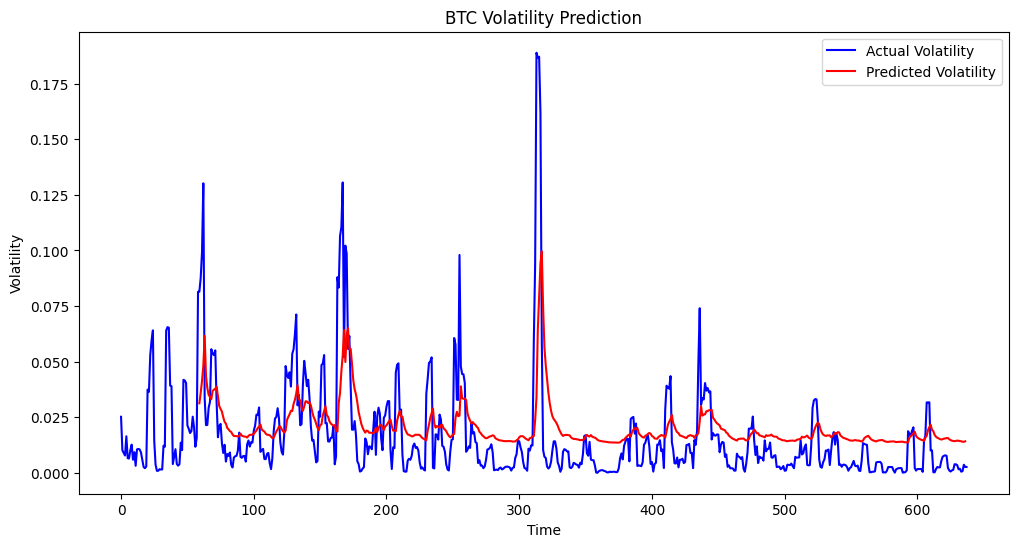

In [40]:
# Now we can evaluate the model on the test set
def evaluate_model(model: LSTM, data: pd.DataFrame):
    """Evaluate the model on the test set."""
    # First, transform the test data into the same format as the training data
    x, y = transform_data_to_training_timeseries(data, window_size=TIMESERIES_LENGTH)
    print(f"Test data shape: {x.shape}, Target shape: {y.shape}")
    prediction = model(x)
    metrics = compute_metrics(prediction, y)

    # add TIMESERIES_LENGTH - 1 to the start of the prediction to align it with the target
    prediction = jnp.concatenate([jnp.full((TIMESERIES_LENGTH -1, 1), jnp.nan), prediction], axis=0)
    return metrics, prediction

# plot the predictions against the actual values
import matplotlib.pyplot as plt
def plot_predictions(predictions: jnp.ndarray, targets: jnp.ndarray):
    """Plot the predictions against the actual values."""
    plt.figure(figsize=(12, 6))
    plt.plot(targets, label='Actual Volatility', color='blue')
    plt.plot(predictions, label='Predicted Volatility', color='red')
    plt.title('BTC Volatility Prediction')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()


# Evaluate the model on the test set
metrics, predictions = evaluate_model(lstm, test_data)
# get the last element of every series in predictions
  # Get the last element of each series
print(metrics)
plot_predictions(predictions, test_data['Target'].to_numpy())